# Time Series Analysis of Real Gross Domestic Product for Canada (1961 - 2024)


In [1]:
# Install required packages if needed
# install.packages(c("ggplot2", "forecast", "TSA", "tseries", "dplyr",
#                   "lubridate", "gridExtra", "MASS", "knitr", "lawstat",
#                   "FinTS", "ggthemes"))


In [12]:
suppressPackageStartupMessages({
  library(ggplot2)
  library(forecast)
  library(tseries)
  library(dplyr)
  library(lubridate)
  library(gridExtra)
  library(MASS)
  library(knitr)
  library(lawstat)
  library(FinTS)
  library(TSA)
})

In [13]:
# Plot settings
options(repr.plot.width = 20, repr.plot.height = 10)
theme_tsa <- function() {
  theme_minimal() +
    theme(
      plot.title = element_text(hjust = 0.5, face = "bold", size = 14),
      plot.subtitle = element_text(hjust = 0.5, size = 12),
      axis.title = element_text(face = "bold"),
      legend.position = "bottom",
      panel.grid.minor = element_line(color = "gray90"),
      panel.grid.major = element_line(color = "gray85")
    )
}

In [14]:
# loading the data and checking it for missing values
# and summary statistics, then printing the results

gdp_df <- read.csv("../data/canada_gdp_quarter.csv")
gdp_df$date <- as.Date(gdp_df$date)
names(gdp_df)[names(gdp_df) == "value"] <- "gdp"  # Rename column if needed

cat("Dataset summary:\n")
print(summary(gdp_df))

cat(
    "\nDate range:", format(min(gdp_df$date), "%Y-%m-%d"),
    "to", format(max(gdp_df$date), "%Y-%m-%d"), "\n"
)

cat(
    "GDP range:", min(gdp_df$gdp),
    "to", max(gdp_df$gdp), "Billions of Chained 2012 Canadian Dollars\n"
)

missing_values <- colSums(is.na(gdp_df))
cat("\nMissing values by column:\n")
print(missing_values)

Dataset summary:
      date                 gdp        
 Min.   :1961-01-01   Min.   : 90981  
 1st Qu.:1976-12-09   1st Qu.:200493  
 Median :1992-11-16   Median :291898  
 Mean   :1992-11-15   Mean   :325718  
 3rd Qu.:2008-10-24   3rd Qu.:459321  
 Max.   :2024-10-01   Max.   :607312  

Date range: 1961-01-01 to 2024-10-01 
GDP range: 90980.8 to 607312.5 Billions of Chained 2012 Canadian Dollars

Missing values by column:
date  gdp 
   0    0 


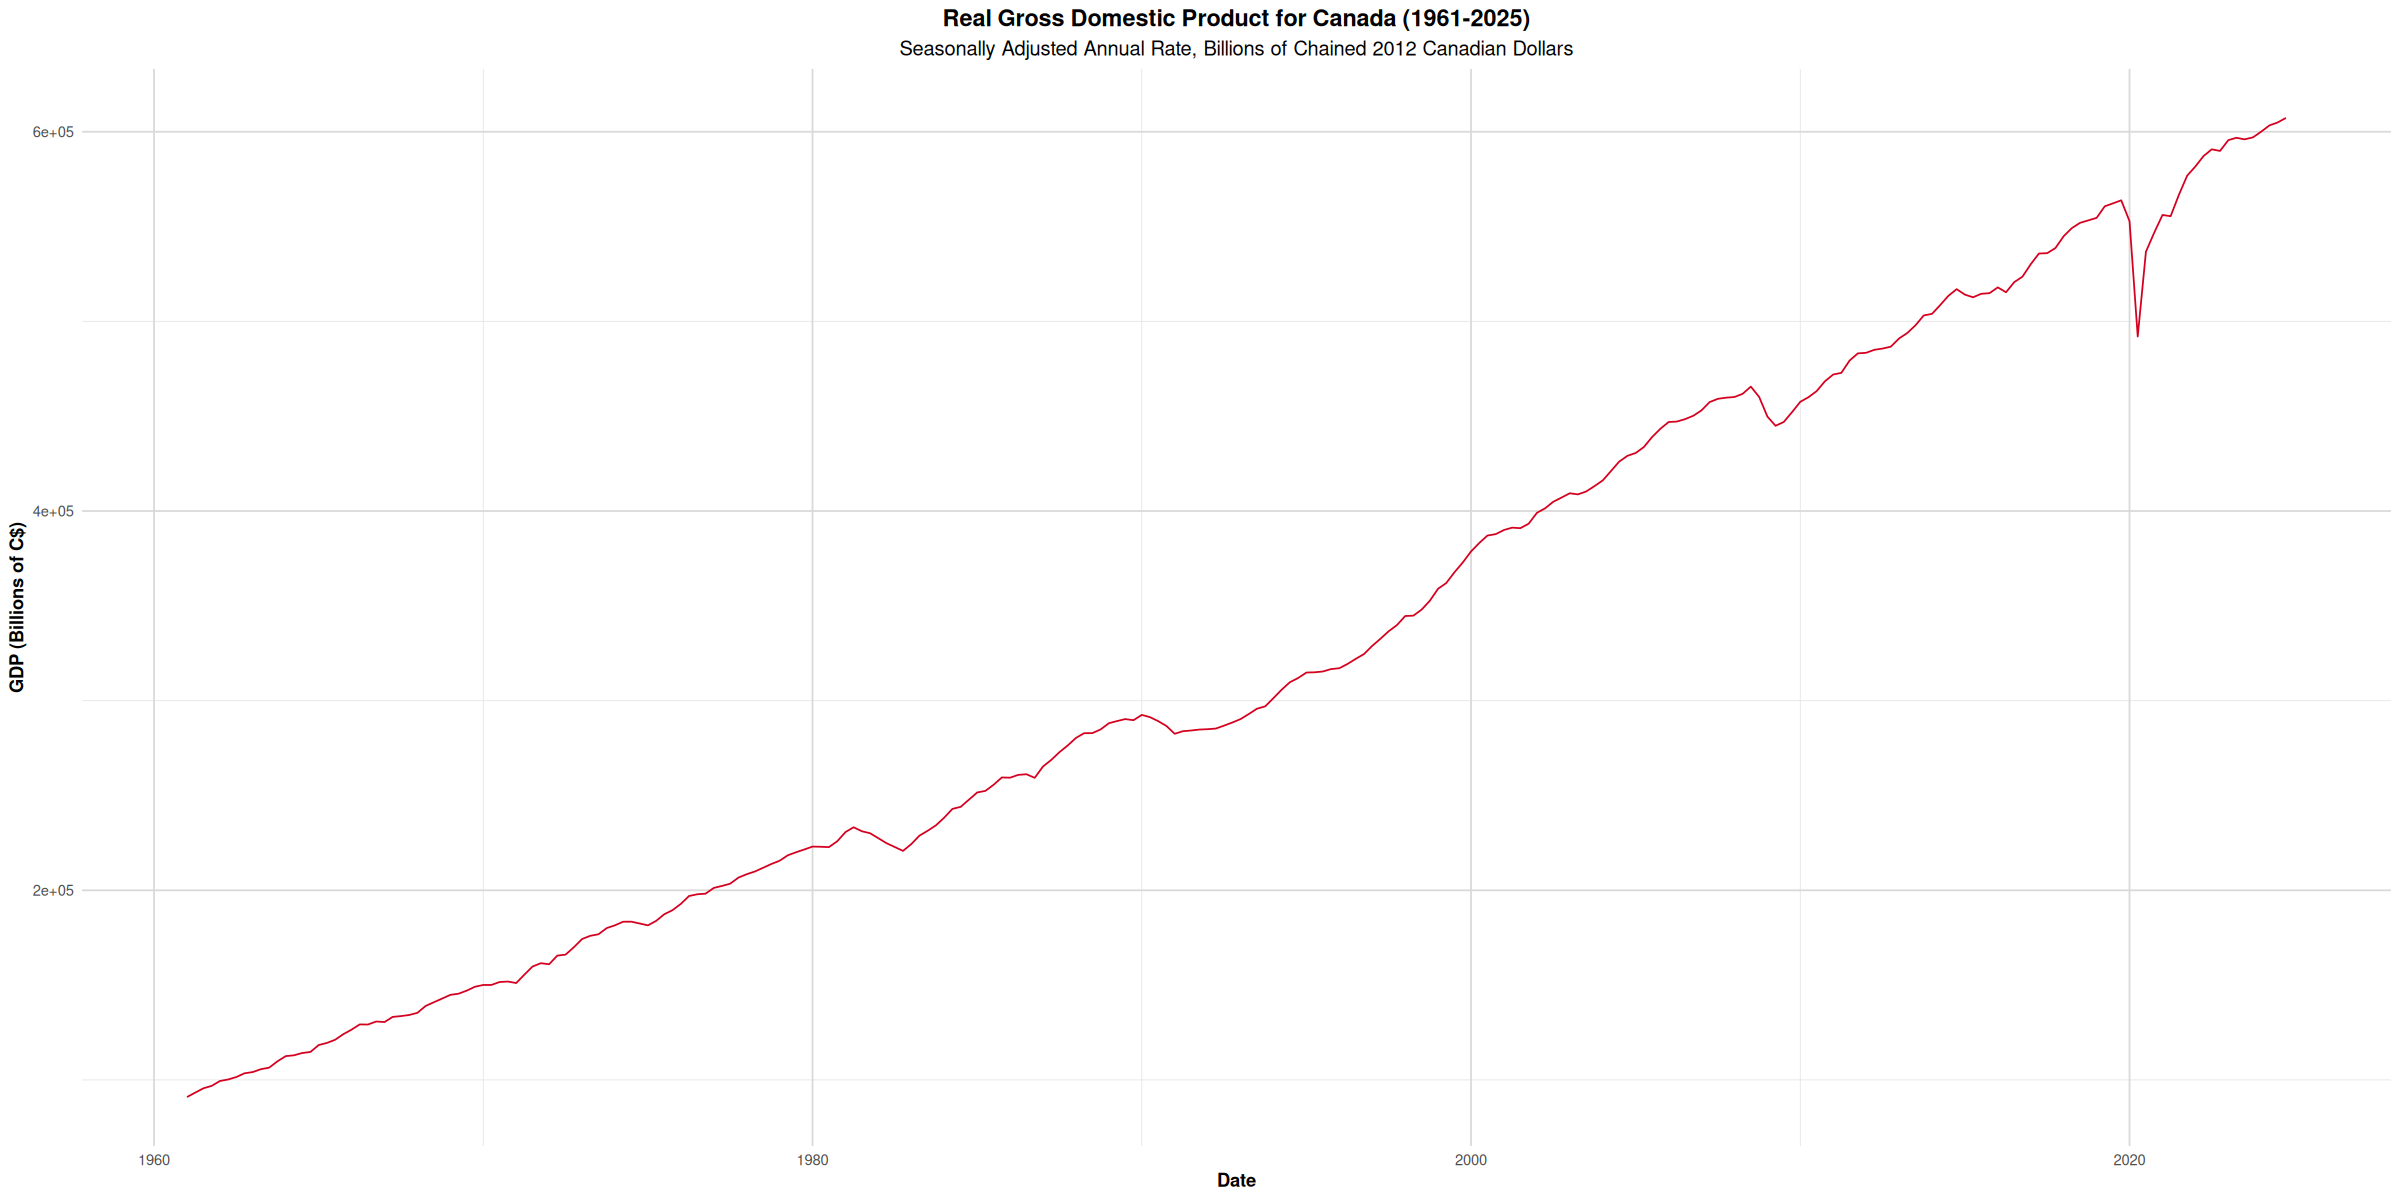

In [ ]:
# plot the series

p1 <- ggplot(gdp_df, aes(x = date, y = gdp)) +
  geom_line(color = "#D4001F") +  
  labs(
    title = "Real Gross Domestic Product for Canada (1961-2025)",
    subtitle = "Seasonally Adjusted Annual Rate, Billions of Chained 2012 Canadian Dollars",
    x = "Date",
    y = "GDP (Billions of C$)"
  ) +
  theme_tsa()

print(p1)

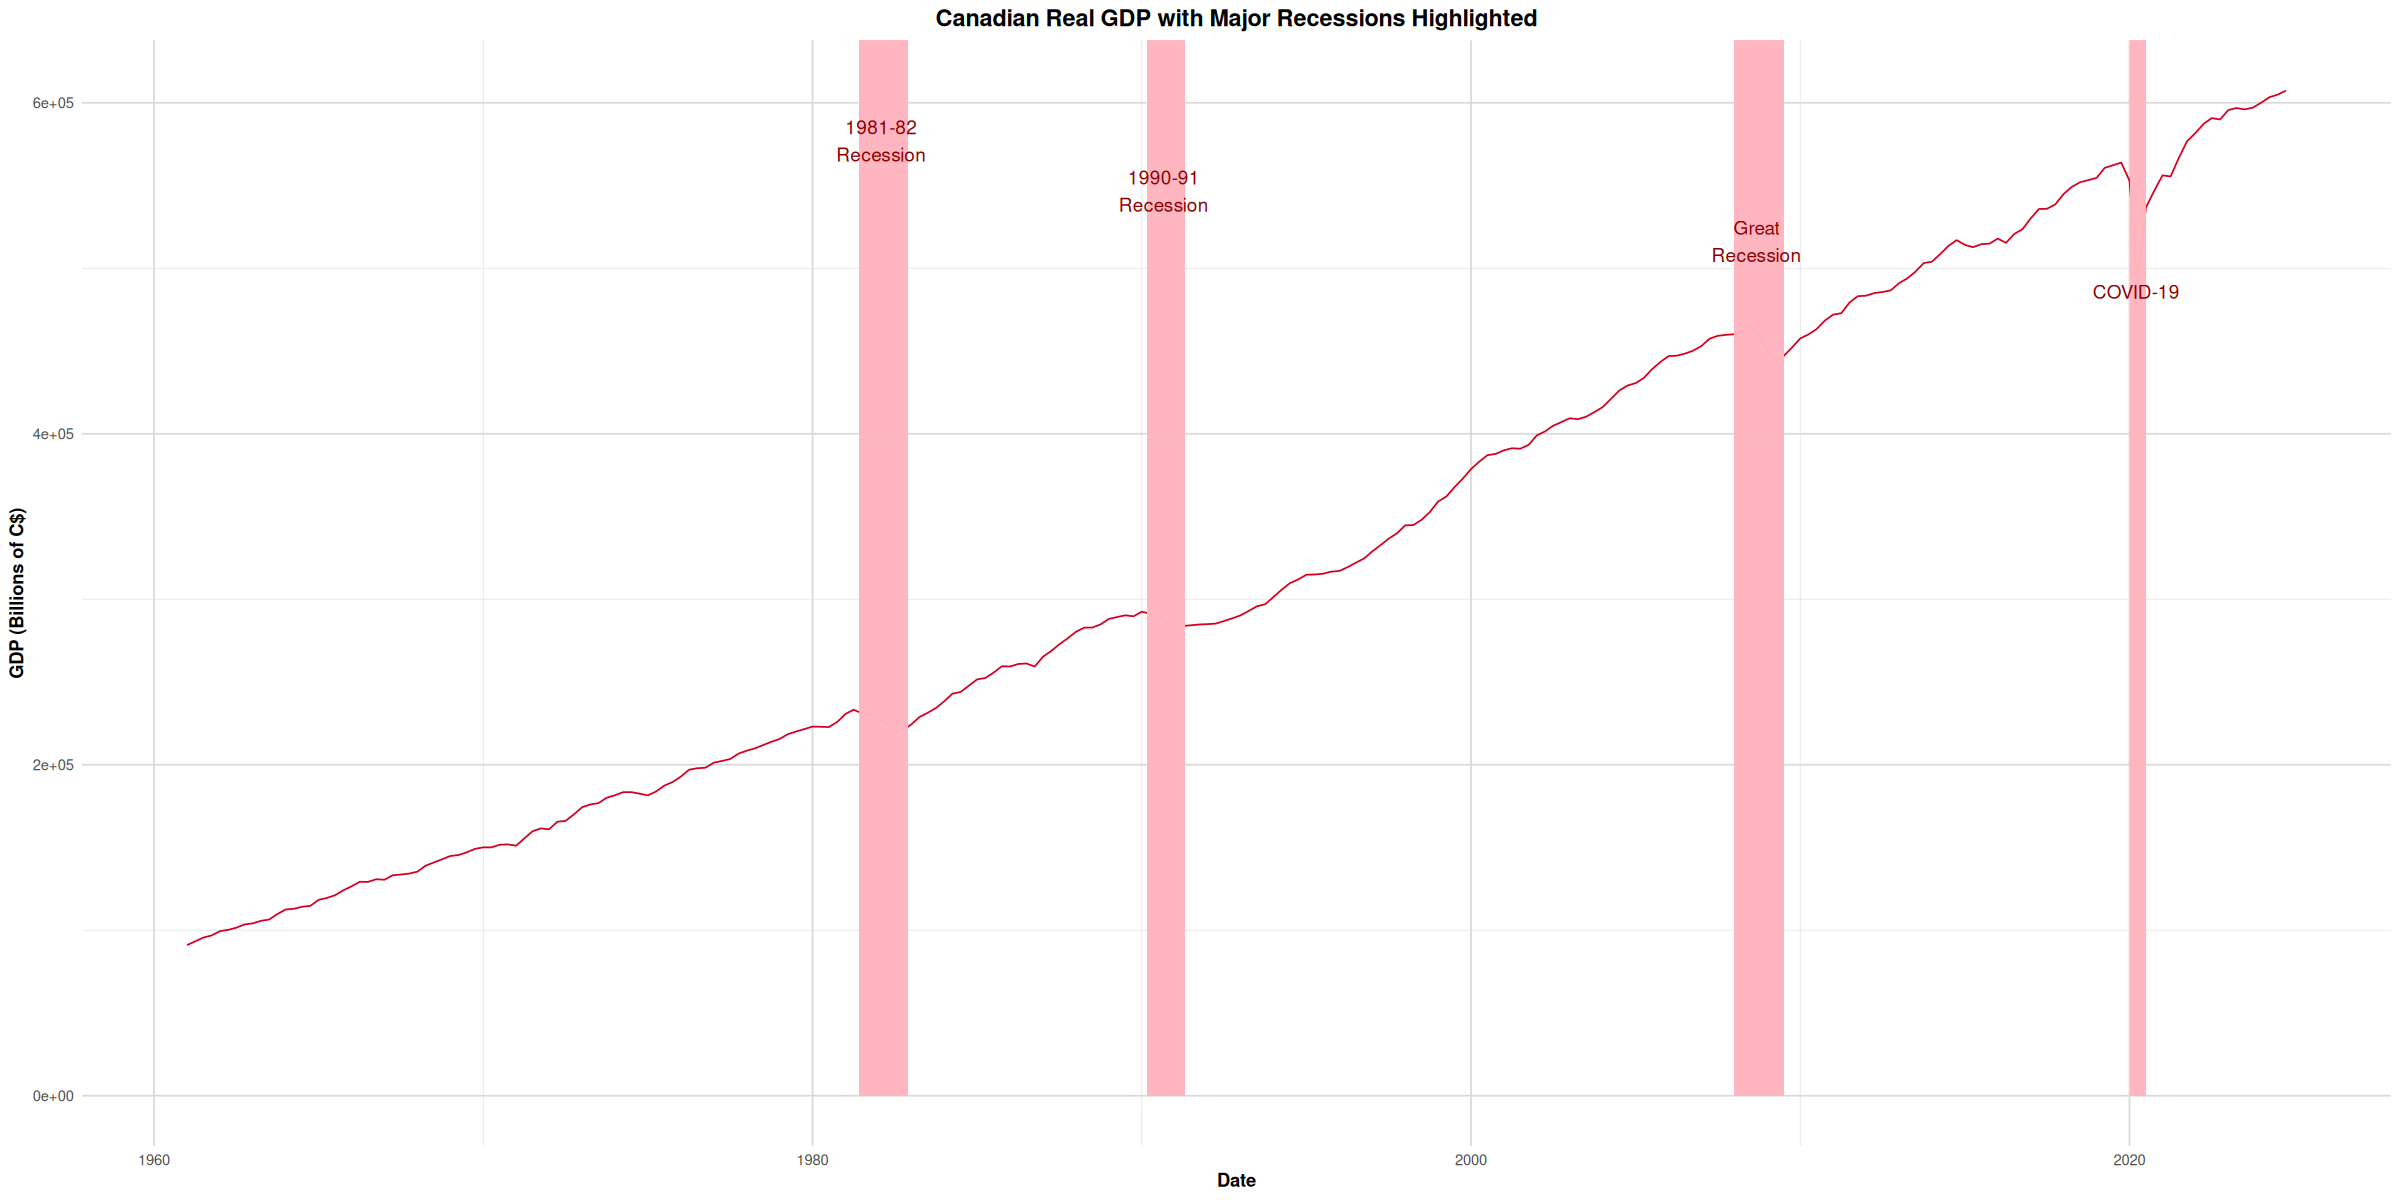

In [16]:
# Highlight key events affecting Canadian economy
p2 <- ggplot(gdp_df, aes(x = date, y = gdp)) +
  geom_line(color = "#D4001F") +
  geom_rect(
    aes(
      xmin = as.Date("1981-06-01"),
      xmax = as.Date("1982-11-30"),
      ymin = 0,
      ymax = Inf
    ),
    fill = "lightpink", alpha = 0.2
  ) +
  geom_rect(
    aes(
      xmin = as.Date("1990-03-01"),
      xmax = as.Date("1991-04-30"),
      ymin = 0,
      ymax = Inf
    ),
    fill = "lightpink", alpha = 0.2
  ) +
  geom_rect(
    aes(
      xmin = as.Date("2008-01-01"),
      xmax = as.Date("2009-06-30"),
      ymin = 0,
      ymax = Inf
    ),
    fill = "lightpink", alpha = 0.2
  ) +
  geom_rect(
    aes(
      xmin = as.Date("2020-01-01"),
      xmax = as.Date("2020-06-30"),
      ymin = 0,
      ymax = Inf
    ),
    fill = "lightpink", alpha = 0.2
  ) +
  annotate("text",
    x = as.Date("1982-02-01"), y = max(gdp_df$gdp) * 0.95,
    label = "1981-82\nRecession", color = "darkred", size = 4
  ) +
  annotate("text",
    x = as.Date("1990-09-01"), y = max(gdp_df$gdp) * 0.90,
    label = "1990-91\nRecession", color = "darkred", size = 4
  ) +
  annotate("text",
    x = as.Date("2008-09-01"), y = max(gdp_df$gdp) * 0.85,
    label = "Great\nRecession", color = "darkred", size = 4
  ) +
  annotate("text",
    x = as.Date("2020-03-15"), y = max(gdp_df$gdp) * 0.80,
    label = "COVID-19", color = "darkred", size = 4
  ) +
  labs(
    title = "Canadian Real GDP with Major Recessions Highlighted",
    x = "Date",
    y = "GDP (Billions of C$)"
  ) +
  theme_tsa()

print(p2)

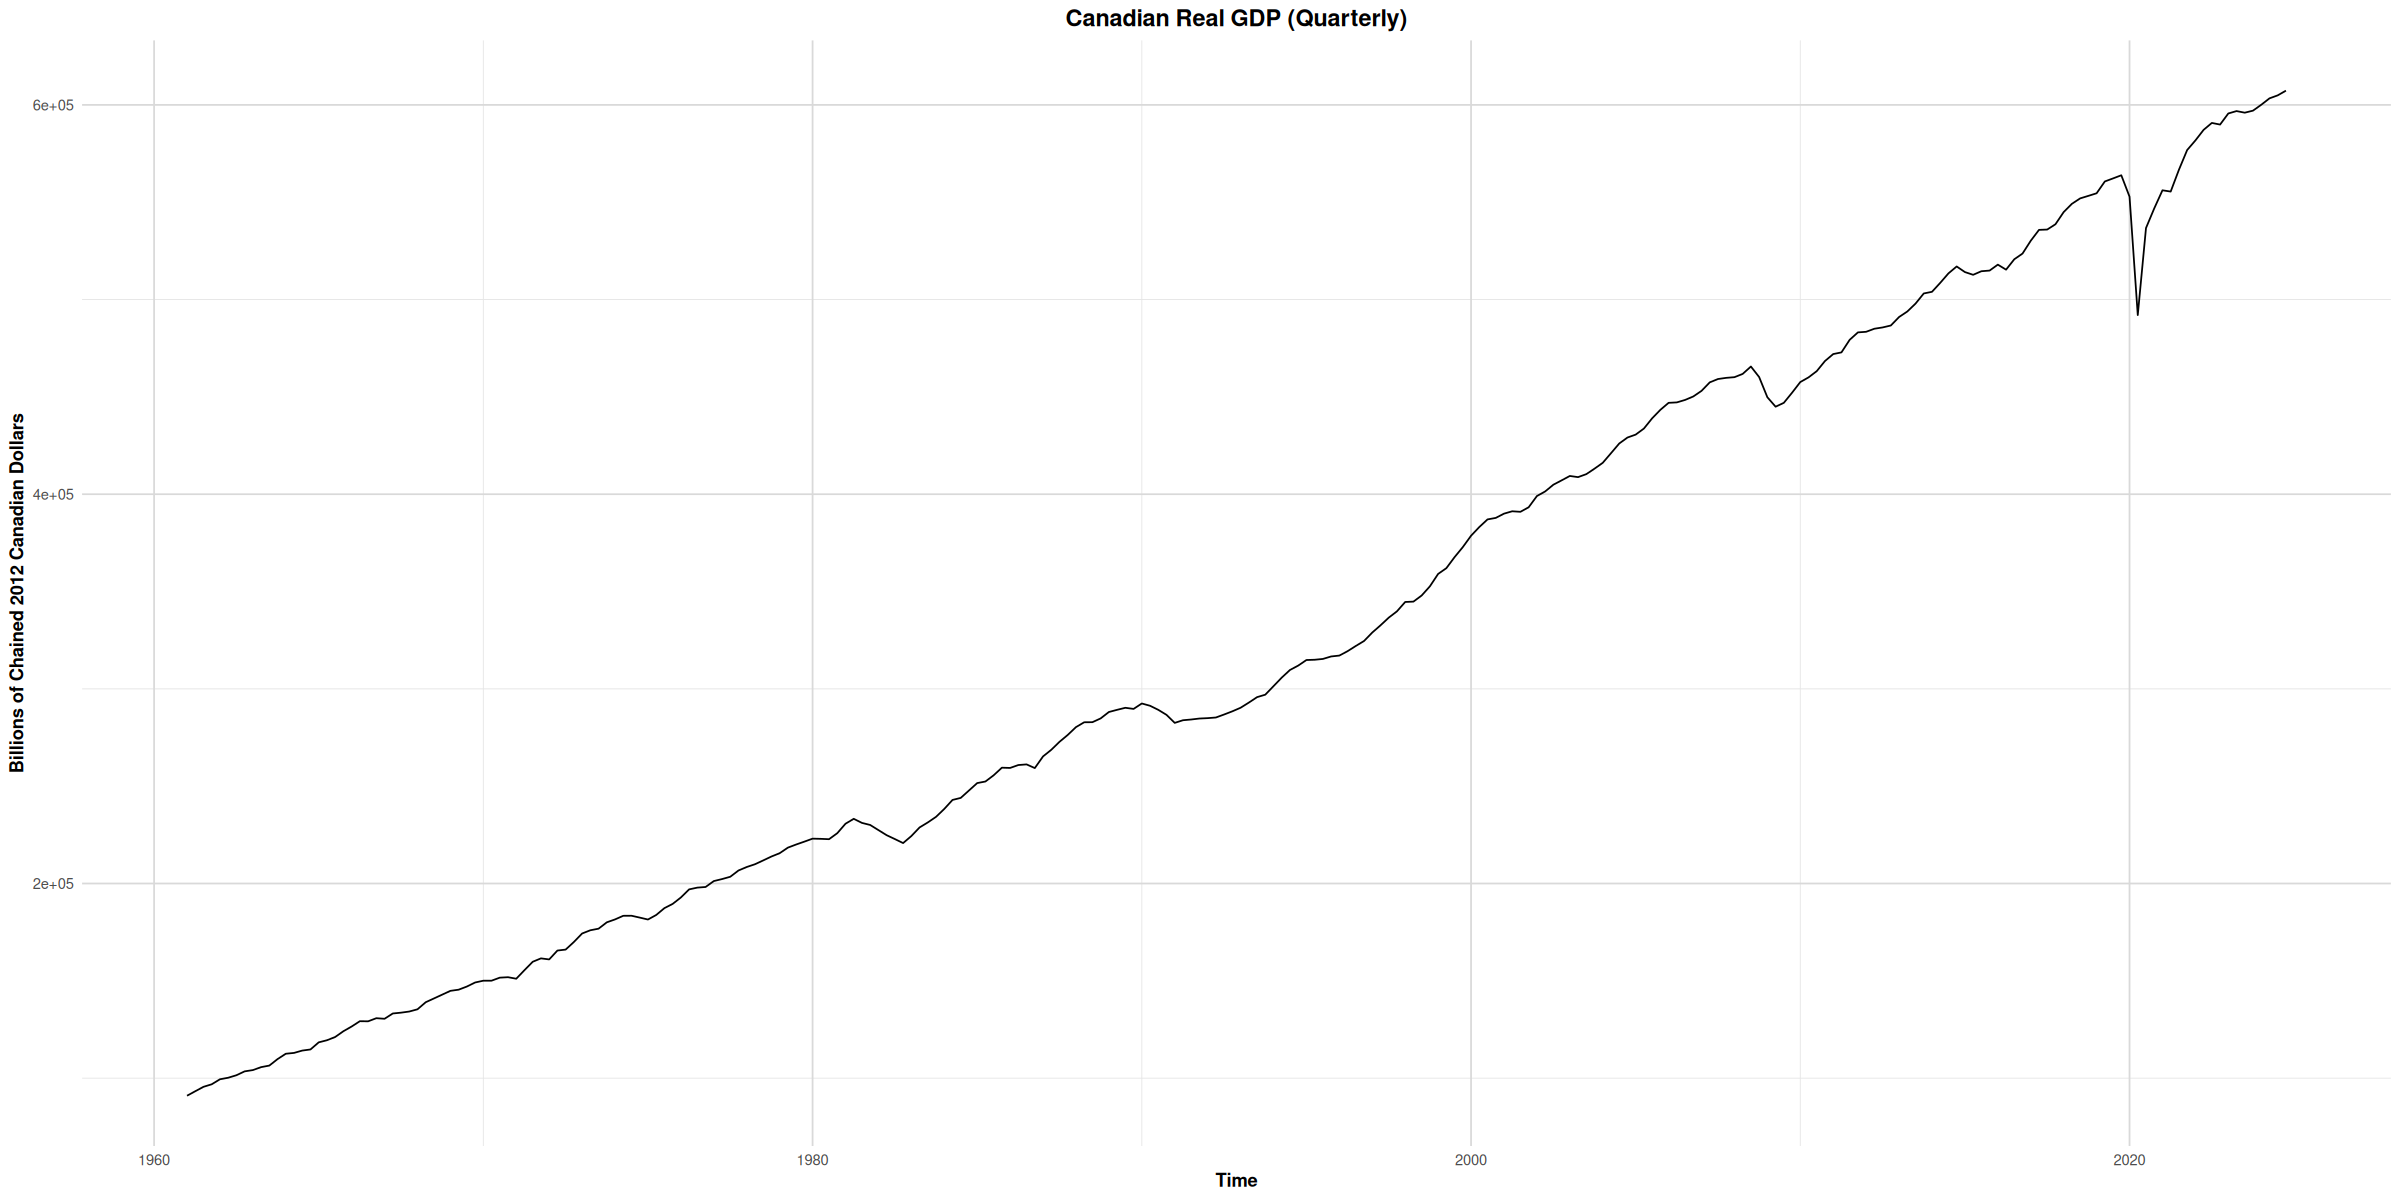

In [17]:
# Create a quarterly time series object (assuming quarterly data)
quarterly_ts <- ts(gdp_df$gdp,
  frequency = 4,  # 4 for quarterly data
  start = c(
    year(min(gdp_df$date)),
    quarter(min(gdp_df$date))
  )
)

# Plot the time series
autoplot(quarterly_ts) +
  labs(
    title = "Canadian Real GDP (Quarterly)",
    x = "Time",
    y = "Billions of Chained 2012 Canadian Dollars"
  ) +
  theme_tsa()

Optimal lambda for Box-Cox transformation: 0.02150376 
Lambda is close to 0, using log transformation


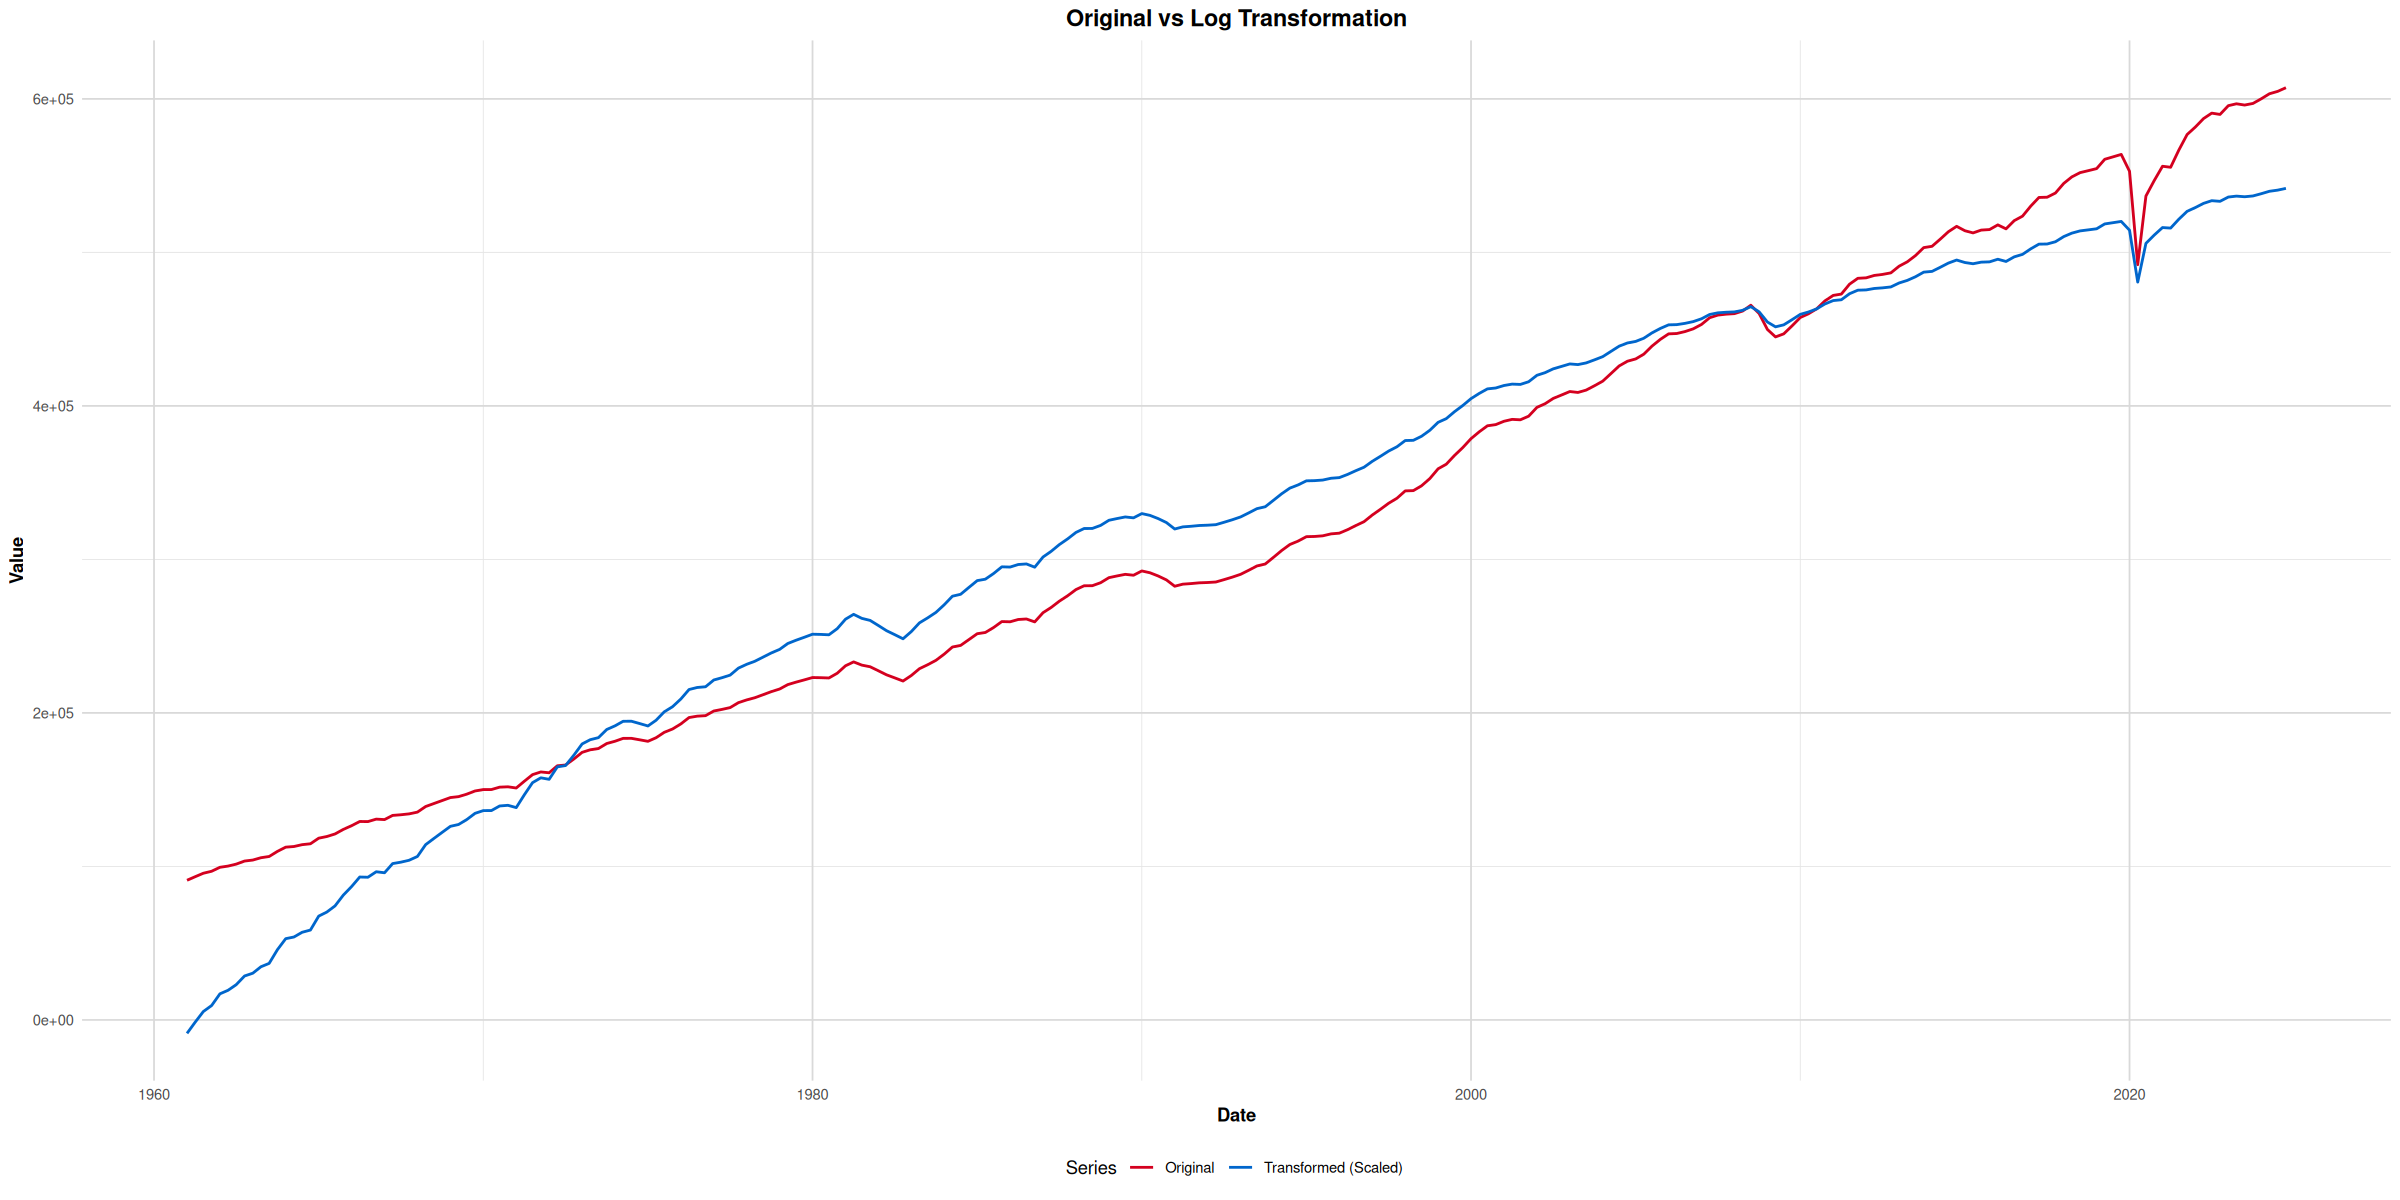

In [19]:
# Determine optimal transformation with Box-Cox
lambda <- BoxCox.lambda(quarterly_ts)
cat("Optimal lambda for Box-Cox transformation:", lambda, "\n")
if (abs(lambda) < 0.1) {
    cat("Lambda is close to 0, using log transformation\n")
    transformed_ts <- log(quarterly_ts)
    transformation_label <- "Log Transformation"
} else if (abs(lambda - 1) < 0.1) {
    cat("Lambda is close to 1, no transformation needed\n")
    transformed_ts <- quarterly_ts
    transformation_label <- "No Transformation"
} else if (lambda == 0) {
    cat("Lambda is 0, using log transformation\n")
    transformed_ts <- log(quarterly_ts)
    transformation_label <- "Log Transformation"
} else {
    cat("Using Box-Cox transformation with lambda =", lambda, "\n")
    transformed_ts <- BoxCox(quarterly_ts, lambda)
    transformation_label <- paste("Box-Cox Transformation (λ =", round(lambda, 4), ")")
}

transformed_df <- data.frame(
    Date = gdp_df$date,
    Original = as.numeric(quarterly_ts),
    Transformed = as.numeric(transformed_ts)
)

p_trans <- ggplot(transformed_df, aes(x = Date)) +
    geom_line(aes(y = Original, color = "Original"), linewidth = 0.8) +
    geom_line(aes(
        y = scale(Transformed) * sd(Original) + mean(Original),
        color = "Transformed (Scaled)"
    ), linewidth = 0.8) +
    labs(
        title = paste("Original vs", transformation_label),
        x = "Date", y = "Value",
        color = "Series"
    ) +
    scale_color_manual(values = c("Original" = "#D4001F", "Transformed (Scaled)" = "#0066CC")) +
    theme_tsa()

print(p_trans)

In [20]:
# Test for stationarity using ADF test and KPSS test
adf_test <- adf.test(transformed_ts, alternative = "stationary")
kpss_test <- kpss.test(transformed_ts, null = "Trend")

cat("ADF Test for Stationarity:\n")
print(adf_test)

cat("\nKPSS Test for Stationarity:\n")
print(kpss_test)

cat("\nConclusion:\n")
if (adf_test$p.value < 0.05) {
    cat("ADF test rejects the null hypothesis, series is stationary\n")
} else {
    cat("ADF test fails to reject the null hypothesis, series is non-stationary\n")
}
if (kpss_test$p.value < 0.05) {
    cat("KPSS test rejects the null hypothesis, series is non-stationary\n")
} else {
    cat("KPSS test fails to reject the null hypothesis, series is stationary\n")
}

Warning message in kpss.test(transformed_ts, null = "Trend"):
“p-value smaller than printed p-value”


ADF Test for Stationarity:

	Augmented Dickey-Fuller Test

data:  transformed_ts
Dickey-Fuller = -2.663, Lag order = 6, p-value = 0.2966
alternative hypothesis: stationary


KPSS Test for Stationarity:

	KPSS Test for Trend Stationarity

data:  transformed_ts
KPSS Trend = 0.81453, Truncation lag parameter = 5, p-value = 0.01


Conclusion:
ADF test fails to reject the null hypothesis, series is non-stationary
KPSS test rejects the null hypothesis, series is non-stationary


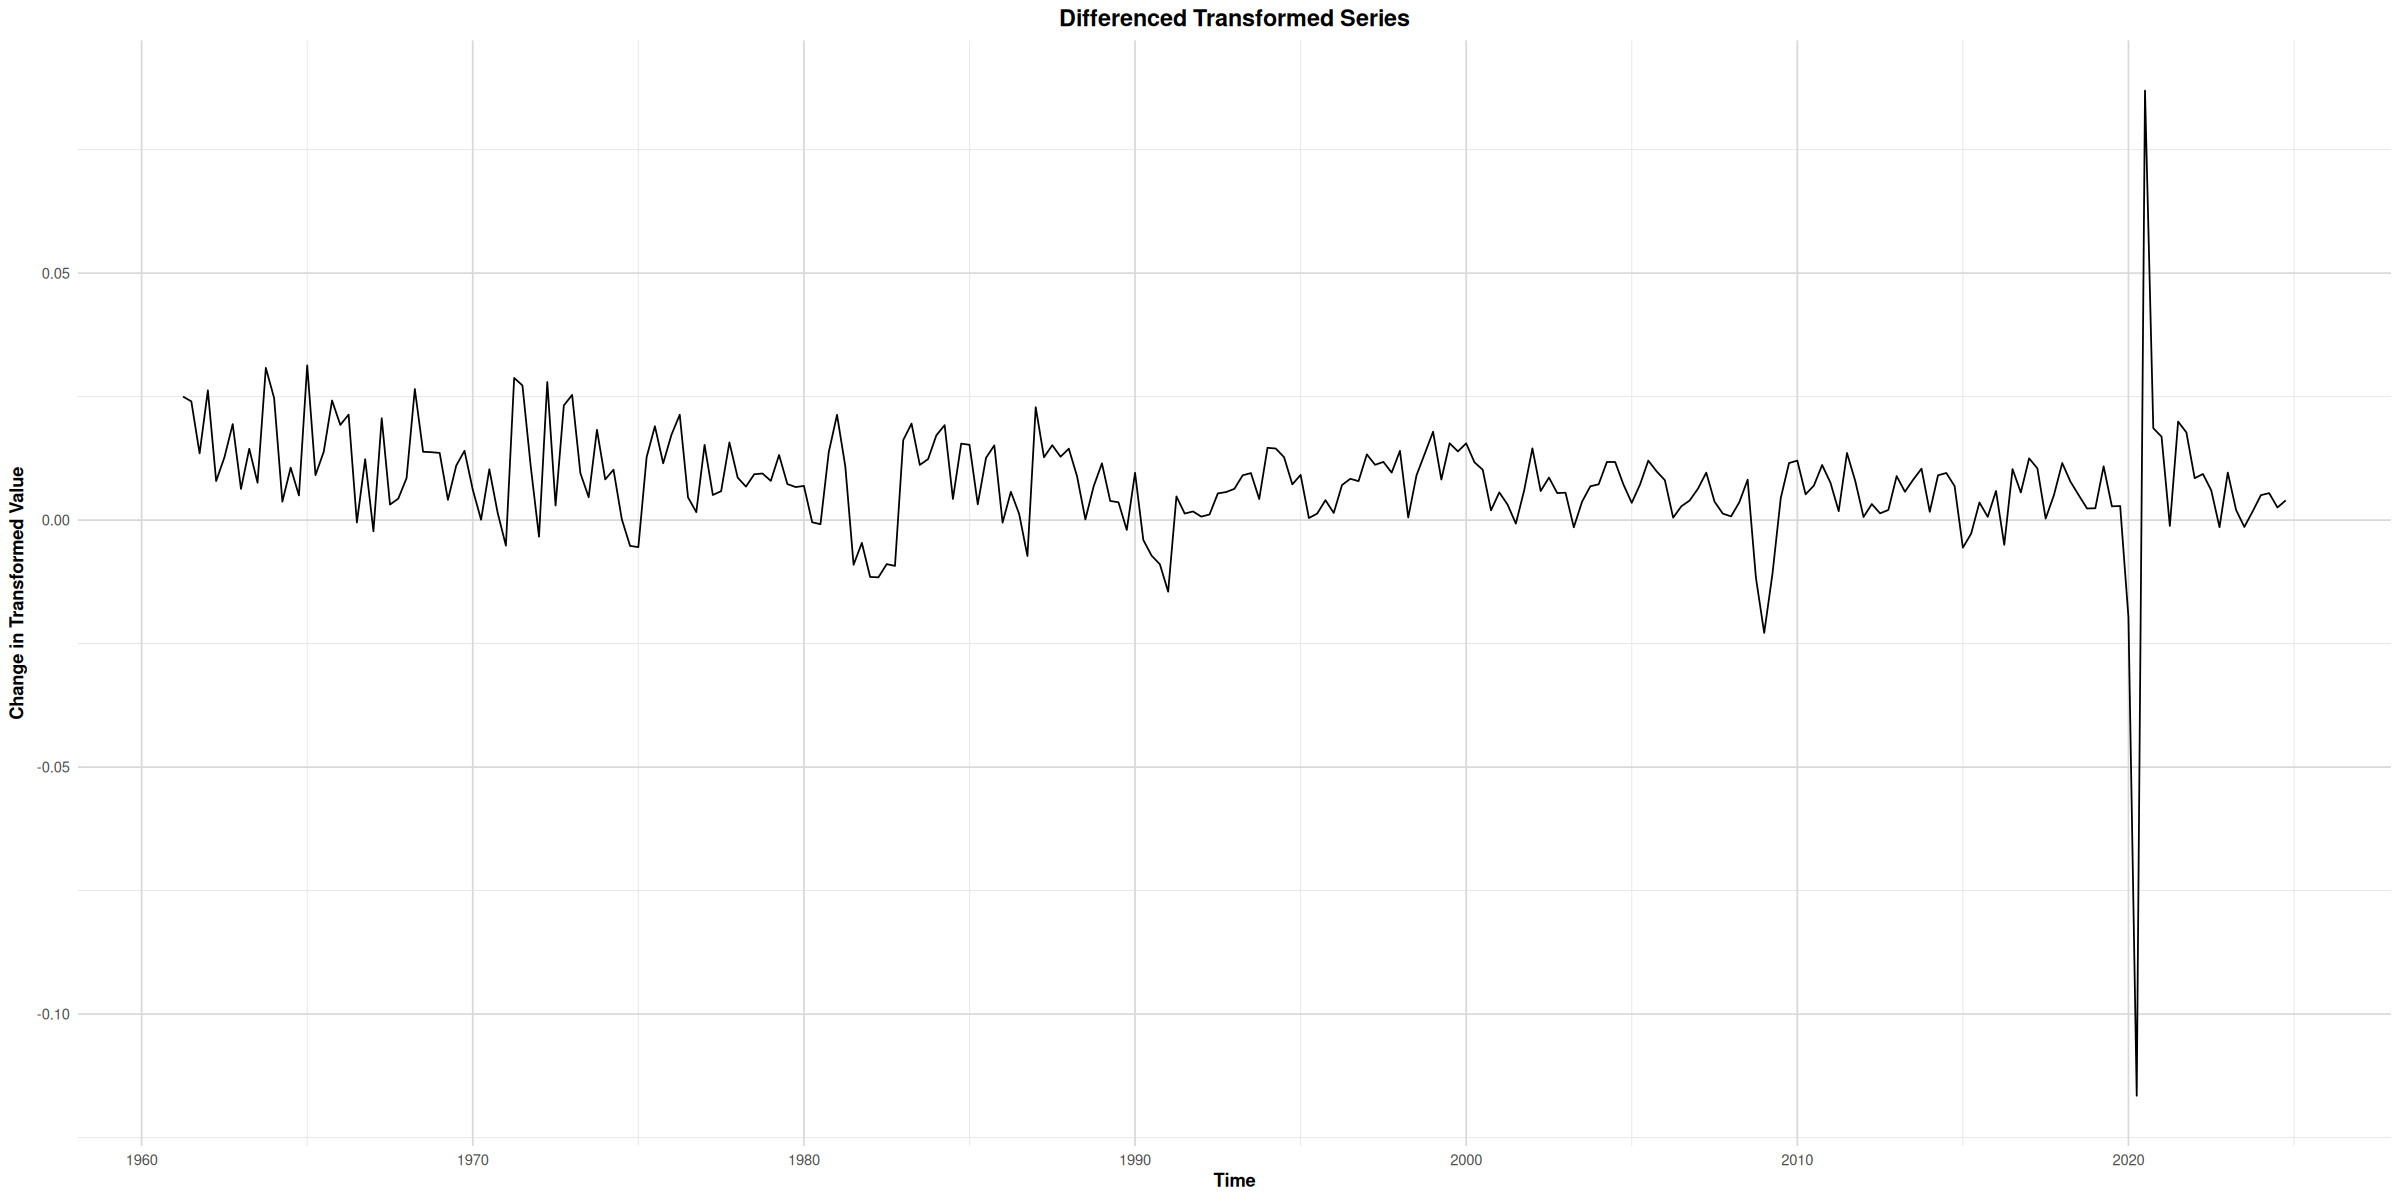

In [21]:
# Differencing to achieve stationarity
diff_ts <- diff(transformed_ts)

p_diff <- autoplot(diff_ts) +
    labs(
        title = "Differenced Transformed Series",
        x = "Time", y = "Change in Transformed Value"
    ) +
    theme_tsa()

print(p_diff)

In [22]:
# Test for stationarity after differencing
adf_test_diff <- adf.test(diff_ts, alternative = "stationary")
kpss_test_diff <- kpss.test(diff_ts, null = "Trend")

cat("ADF Test for Stationarity (After Differencing):\n")
print(adf_test_diff)

cat("\nKPSS Test for Stationarity (After Differencing):\n")
print(kpss_test_diff)

cat("\nConclusion (After Differencing):\n")
if (adf_test_diff$p.value < 0.05) {
    cat("ADF test rejects the null hypothesis, series is stationary\n")
} else {
    cat("ADF test fails to reject the null hypothesis, series is non-stationary\n")
}
if (kpss_test_diff$p.value < 0.05) {
    cat("KPSS test rejects the null hypothesis, series is non-stationary\n")
} else {
    cat("KPSS test fails to reject the null hypothesis, series is stationary\n")
}

Warning message in adf.test(diff_ts, alternative = "stationary"):
“p-value smaller than printed p-value”
Warning message in kpss.test(diff_ts, null = "Trend"):
“p-value greater than printed p-value”


ADF Test for Stationarity (After Differencing):

	Augmented Dickey-Fuller Test

data:  diff_ts
Dickey-Fuller = -6.3463, Lag order = 6, p-value = 0.01
alternative hypothesis: stationary


KPSS Test for Stationarity (After Differencing):

	KPSS Test for Trend Stationarity

data:  diff_ts
KPSS Trend = 0.094497, Truncation lag parameter = 5, p-value = 0.1


Conclusion (After Differencing):
ADF test rejects the null hypothesis, series is stationary
KPSS test fails to reject the null hypothesis, series is stationary


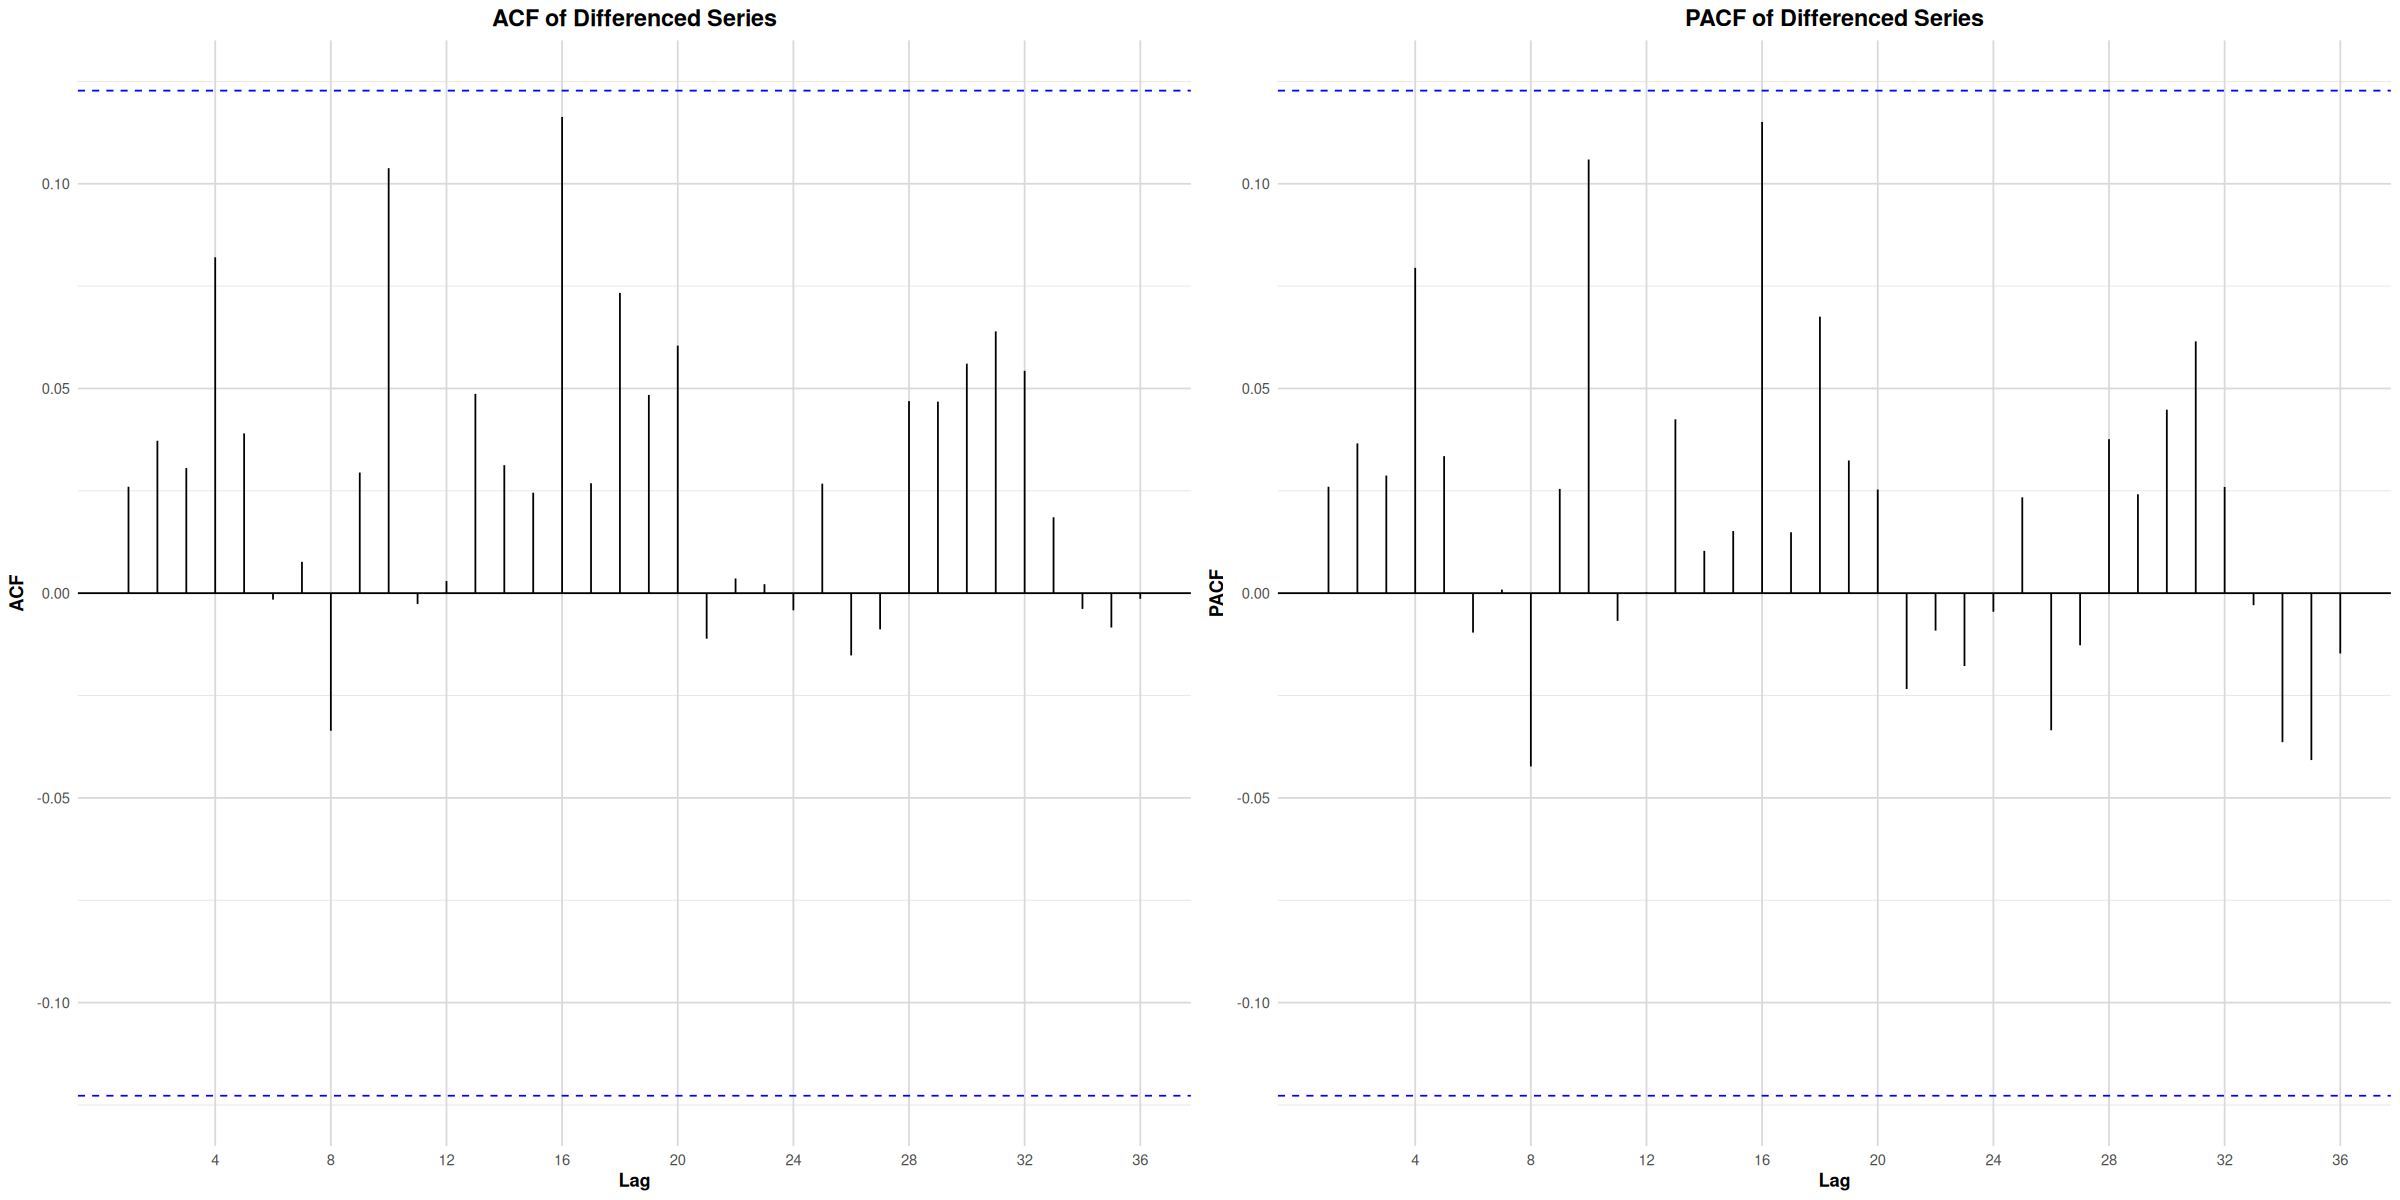

In [23]:
# ACF and PACF plots for differenced series
p_acf_diff <- ggAcf(diff_ts, lag = 36) +
    labs(
        title = "ACF of Differenced Series",
        x = "Lag", y = "ACF"
    ) +
    theme_tsa()

p_pacf_diff <- ggAcf(diff_ts, lag = 36, type = "partial") +
    labs(
        title = "PACF of Differenced Series",
        x = "Lag", y = "PACF"
    ) +
    theme_tsa()

grid.arrange(p_acf_diff, p_pacf_diff, ncol = 2)

Warning message in leaps.setup(x, y, wt = wt, nbest = nbest, nvmax = nvmax, force.in = force.in, :
“10  linear dependencies found”


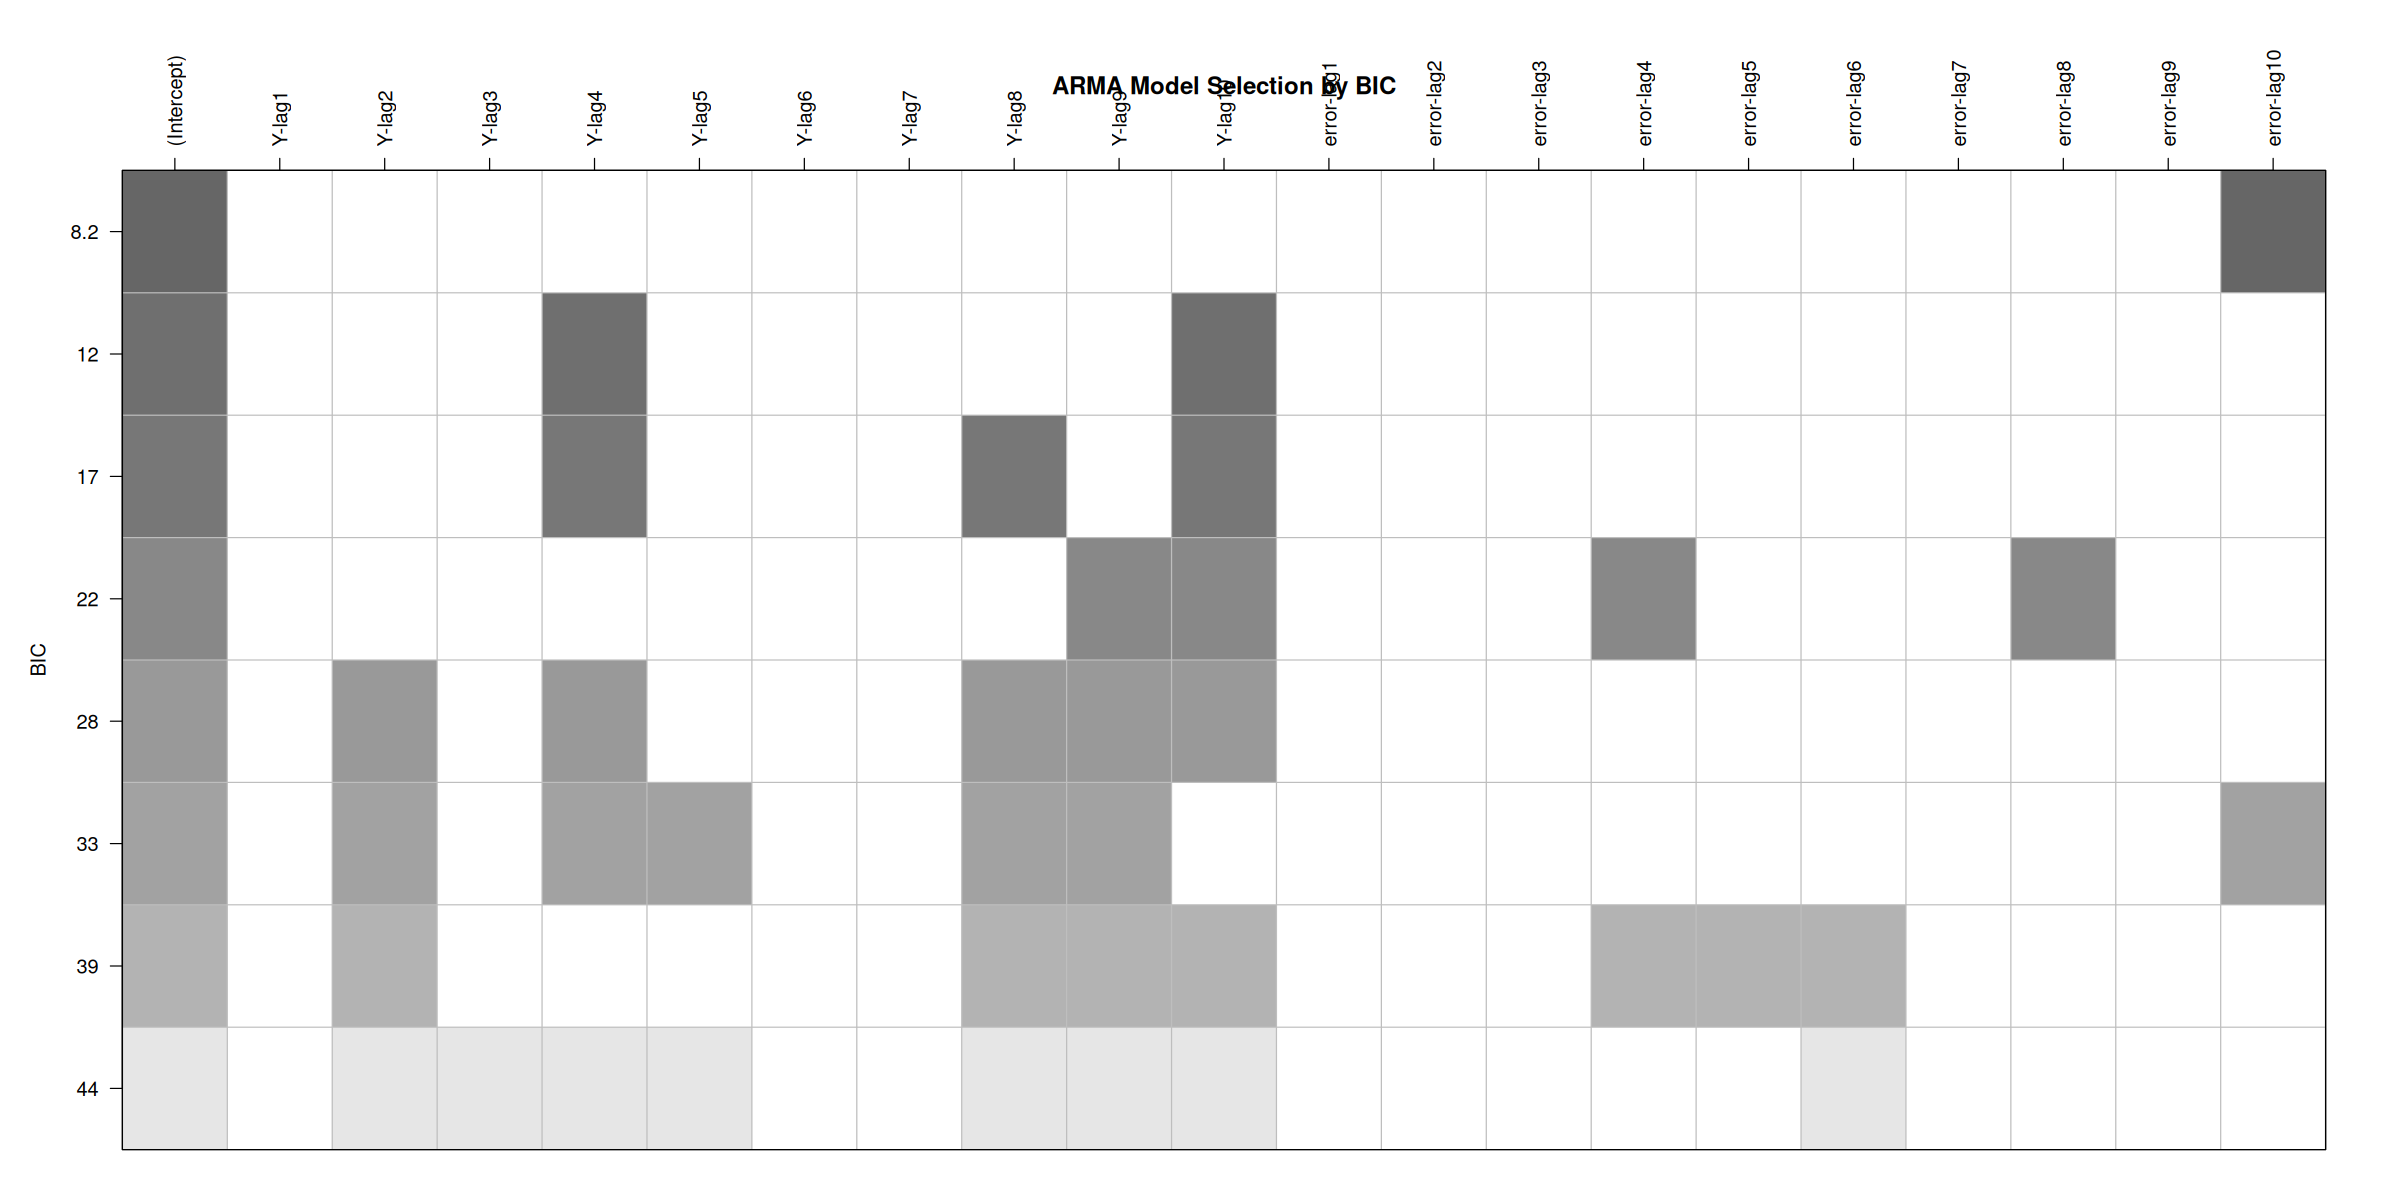

In [24]:
# Model identification using armasubsets
subset_results <- armasubsets(y = diff_ts, nar = 10, nma = 10,
                              ar.method = "ols")

# Plot results
par(bg = "white")
plot(subset_results, which = "bic", main = "ARMA Model Selection by BIC",
     xlab = "AR and MA terms", ylab = "BIC", cex.axis = 1, cex.lab = 1)

**Top 2 models using armasubsets() :**
- ARIMA(0,1,10)
- ARIMA(10,1,0)

In [25]:
# Grid search for best ARIMA models
max_p <- 8
max_q <- 8
d <- 1

aic_values <- matrix(NA, nrow = max_p + 1, ncol = max_q + 1)
bic_values <- matrix(NA, nrow = max_p + 1, ncol = max_q + 1)

cat("\nFitting ARIMA models with different orders...\n")
for (p in 0:max_p) {
  for (q in 0:max_q) {
    if (p == 0 && q == 0) next
    
    cat(sprintf("Fitting ARIMA(%d,%d,%d)...\n", p, d, q))
    
    tryCatch({
      # Using transformed_ts for consistency
      model <- Arima(transformed_ts, order = c(p, d, q))
      aic_values[p+1, q+1] <- model$aic
      bic_values[p+1, q+1] <- model$bic
    }, error = function(e) {
      cat("  Error:", e$message, "\n")
    })
  }
}

model_data <- data.frame(
  p = rep(0:max_p, each = max_q + 1),
  q = rep(0:max_q, max_p + 1),
  AIC = as.vector(aic_values),
  BIC = as.vector(bic_values)
)

model_data <- model_data[!is.na(model_data$AIC) & !is.na(model_data$BIC), ]
model_data$Model <- paste0("(", model_data$p, ",1,", model_data$q, ")")

best_aic_model <- model_data[which.min(model_data$AIC), ]
best_bic_model <- model_data[which.min(model_data$BIC), ]

cat("\nBest model by AIC: ARIMA", best_aic_model$Model, "with AIC =", round(best_aic_model$AIC, 2), "\n")
cat("Best model by BIC: ARIMA", best_bic_model$Model, "with BIC =", round(best_bic_model$BIC, 2), "\n")


Fitting ARIMA models with different orders...


Fitting ARIMA(0,1,1)...
Fitting ARIMA(0,1,2)...
Fitting ARIMA(0,1,3)...
Fitting ARIMA(0,1,4)...
Fitting ARIMA(0,1,5)...
Fitting ARIMA(0,1,6)...
Fitting ARIMA(0,1,7)...
Fitting ARIMA(0,1,8)...
Fitting ARIMA(1,1,0)...
Fitting ARIMA(1,1,1)...
Fitting ARIMA(1,1,2)...
Fitting ARIMA(1,1,3)...
Fitting ARIMA(1,1,4)...
Fitting ARIMA(1,1,5)...
Fitting ARIMA(1,1,6)...
Fitting ARIMA(1,1,7)...
Fitting ARIMA(1,1,8)...
Fitting ARIMA(2,1,0)...
Fitting ARIMA(2,1,1)...
Fitting ARIMA(2,1,2)...
Fitting ARIMA(2,1,3)...
Fitting ARIMA(2,1,4)...
Fitting ARIMA(2,1,5)...
Fitting ARIMA(2,1,6)...
Fitting ARIMA(2,1,7)...
Fitting ARIMA(2,1,8)...
Fitting ARIMA(3,1,0)...
Fitting ARIMA(3,1,1)...
Fitting ARIMA(3,1,2)...
Fitting ARIMA(3,1,3)...
Fitting ARIMA(3,1,4)...
Fitting ARIMA(3,1,5)...
Fitting ARIMA(3,1,6)...
Fitting ARIMA(3,1,7)...
Fitting ARIMA(3,1,8)...
Fitting ARIMA(4,1,0)...
Fitting ARIMA(4,1,1)...
Fitting ARIMA(4,1,2)...
Fitting ARIMA(4,1,3)...
Fitting ARIMA(4,1,4)...
Fitting ARIMA(4,1,5)...
Fitting ARIMA(4,

**The best models using grid search are:**
- Best model by AIC & BIC : Best model by AIC: ARIMA (1,1,1) with AIC = -1507.25 & BIC = -1496.62 

In [26]:
# Split data for training and testing
n_quarters <- length(transformed_ts)
train_end <- n_quarters - 12  # Use last 3 years (12 quarters) for testing

train_ts <- window(transformed_ts, end = c(time(transformed_ts)[train_end]))
test_ts <- window(transformed_ts, start = c(time(transformed_ts)[train_end + 1]))

# Define candidate models
candidate_models <- list(
  list(p=1, d=1, q=1, name="ARIMA(1,1,1) - Best AIC & BIC (Grid Search)"),
  list(p=0, d=1, q=10, name="ARIMA(0,1,10) - Top ARMASUBSETS Model"),
  list(p=10, d=1, q=0, name="ARIMA(10,1,0) - Top ARMASUBSETS Model")
)

# Add best AIC and BIC models if not already in the list
if (!paste0("(", best_aic_model$p, ",1,", best_aic_model$q, ")") %in% sapply(candidate_models, function(x) paste0("(", x$p, ",1,", x$q, ")"))) {
  candidate_models <- c(candidate_models, list(list(
    p=best_aic_model$p, d=1, q=best_aic_model$q, 
    name=paste0("ARIMA", best_aic_model$Model, " - Best AIC")
  )))
}

if (!paste0("(", best_bic_model$p, ",1,", best_bic_model$q, ")") %in% sapply(candidate_models, function(x) paste0("(", x$p, ",1,", x$q, ")"))) {
  candidate_models <- c(candidate_models, list(list(
    p=best_bic_model$p, d=1, q=best_bic_model$q, 
    name=paste0("ARIMA", best_bic_model$Model, " - Best BIC")
  )))
}

# Fit models and evaluate forecasts
forecast_results <- data.frame(
  Model = character(),
  RMSE = numeric(),
  MAE = numeric(),
  MAPE = numeric(),
  stringsAsFactors = FALSE
)

fitted_models <- list()

for (model in candidate_models) {
  model_name <- model$name
  p <- model$p
  d <- model$d
  q <- model$q
  
  cat(sprintf("\nFitting %s...\n", model_name))
  
  tryCatch({
    # Fit model
    arima_model <- Arima(train_ts, order = c(p, d, q))
    fitted_models[[model_name]] <- arima_model
    
    # Generate forecasts
    h <- length(test_ts)
    forecasts <- forecast(arima_model, h = h)
    
    # Calculate error metrics
    errors <- test_ts - forecasts$mean
    rmse <- sqrt(mean(errors^2))
    mae <- mean(abs(errors))
    mape <- mean(abs(errors / test_ts)) * 100
    
    cat(sprintf("RMSE: %.4f, MAE: %.4f, MAPE: %.2f%%\n", rmse, mae, mape))
    
    # Add to results
    forecast_results <- rbind(forecast_results, data.frame(
      Model = model_name,
      RMSE = rmse,
      MAE = mae,
      MAPE = mape
    ))
    
  }, error = function(e) {
    cat("  Error:", e$message, "\n")
  })
}

# Sort by RMSE
forecast_results <- forecast_results[order(forecast_results$RMSE), ]
rownames(forecast_results) <- NULL

cat("\nOut-of-sample forecast accuracy comparison:\n")
print(forecast_results)

# Identify best model
best_model_name <- forecast_results$Model[1]
cat("\nBest model based on forecast accuracy (RMSE):", best_model_name, "\n")


Fitting ARIMA(1,1,1) - Best AIC & BIC (Grid Search)...
RMSE: 0.0056, MAE: 0.0050, MAPE: 0.04%

Fitting ARIMA(0,1,10) - Top ARMASUBSETS Model...
RMSE: 0.0085, MAE: 0.0067, MAPE: 0.05%

Fitting ARIMA(10,1,0) - Top ARMASUBSETS Model...
RMSE: 0.0169, MAE: 0.0124, MAPE: 0.09%

Out-of-sample forecast accuracy comparison:
                                        Model        RMSE         MAE
1 ARIMA(1,1,1) - Best AIC & BIC (Grid Search) 0.005576808 0.005041184
2       ARIMA(0,1,10) - Top ARMASUBSETS Model 0.008506479 0.006701798
3       ARIMA(10,1,0) - Top ARMASUBSETS Model 0.016918901 0.012408489
        MAPE
1 0.03791252
2 0.05041115
3 0.09334452

Best model based on forecast accuracy (RMSE): ARIMA(1,1,1) - Best AIC & BIC (Grid Search) 


Fitting ARIMA(1,1,1) on full data



	Ljung-Box test

data:  Residuals from ARIMA(1,1,1)
Q* = 4.0842, df = 6, p-value = 0.6653

Model df: 2.   Total lags used: 8



Don't know how to automatically pick scale for object of type <ts>. Defaulting
to continuous.
Don't know how to automatically pick scale for object of type <ts>. Defaulting
to continuous.


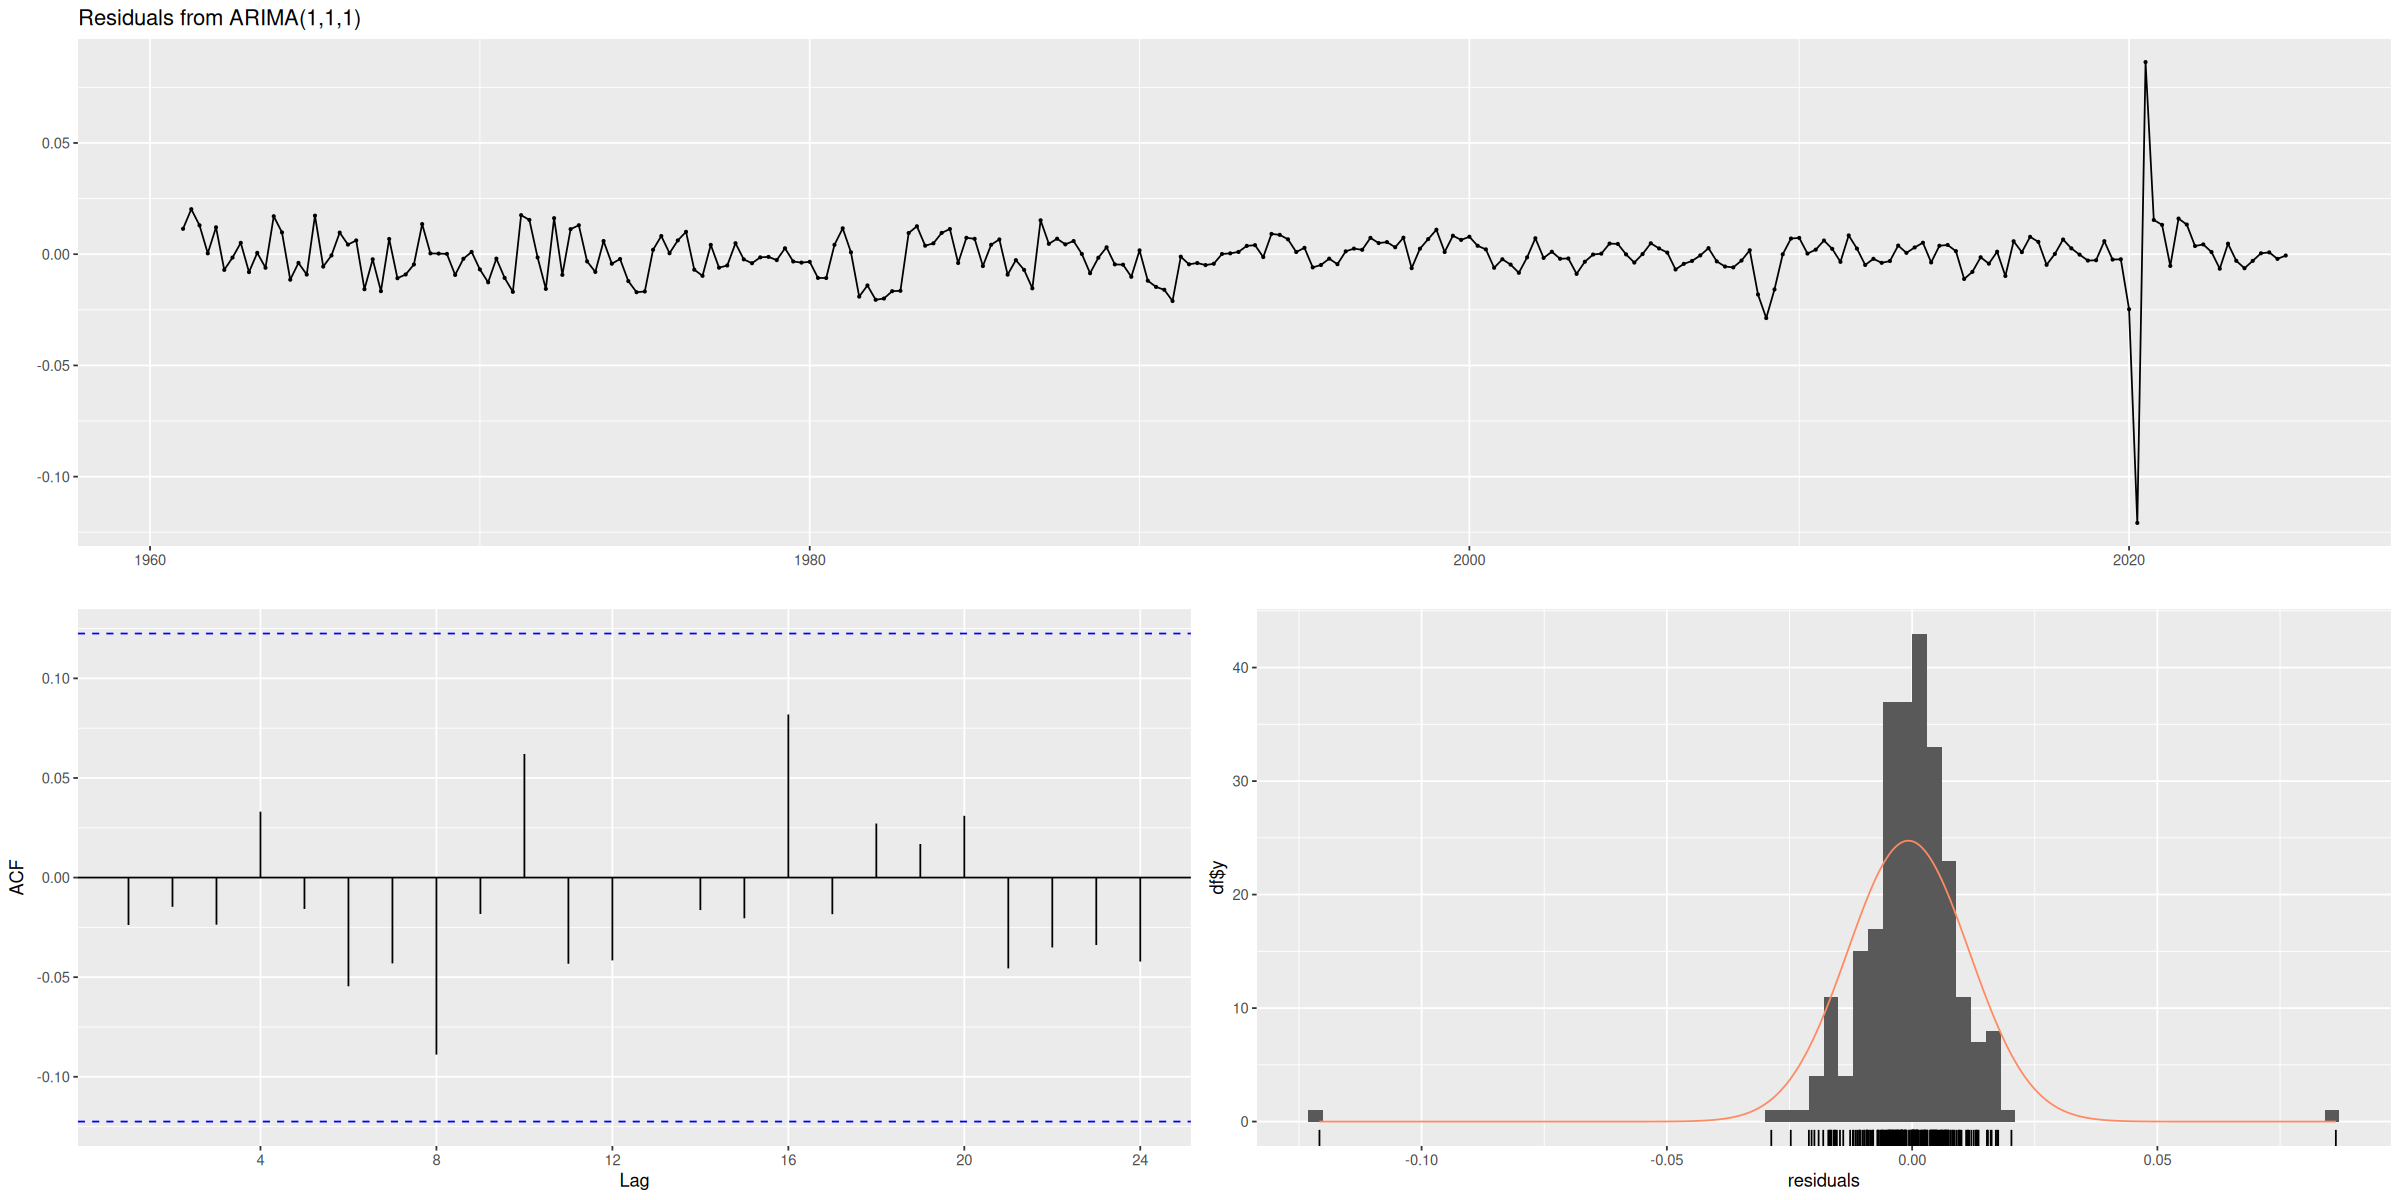


Shapiro-Wilk test for normality:

	Shapiro-Wilk normality test

data:  residuals(final_model)
W = 0.69179, p-value < 2.2e-16

Interpretation: p-value < 0.05, residuals not normally distributed 

Ljung-Box test for autocorrelation:

	Box-Ljung test

data:  residuals(final_model)
X-squared = 6.1793, df = 12, p-value = 0.9068

Interpretation: p-value > 0.05, no significant autocorrelation remains 

ARCH test for conditional heteroskedasticity:

	ARCH LM-test; Null hypothesis: no ARCH effects

data:  residuals(final_model)
Chi-squared = 57.415, df = 12, p-value = 6.65e-08

Interpretation: p-value < 0.05, ARCH effects present 

Runs test could not be calculated. Consider checking for constant values in residuals.


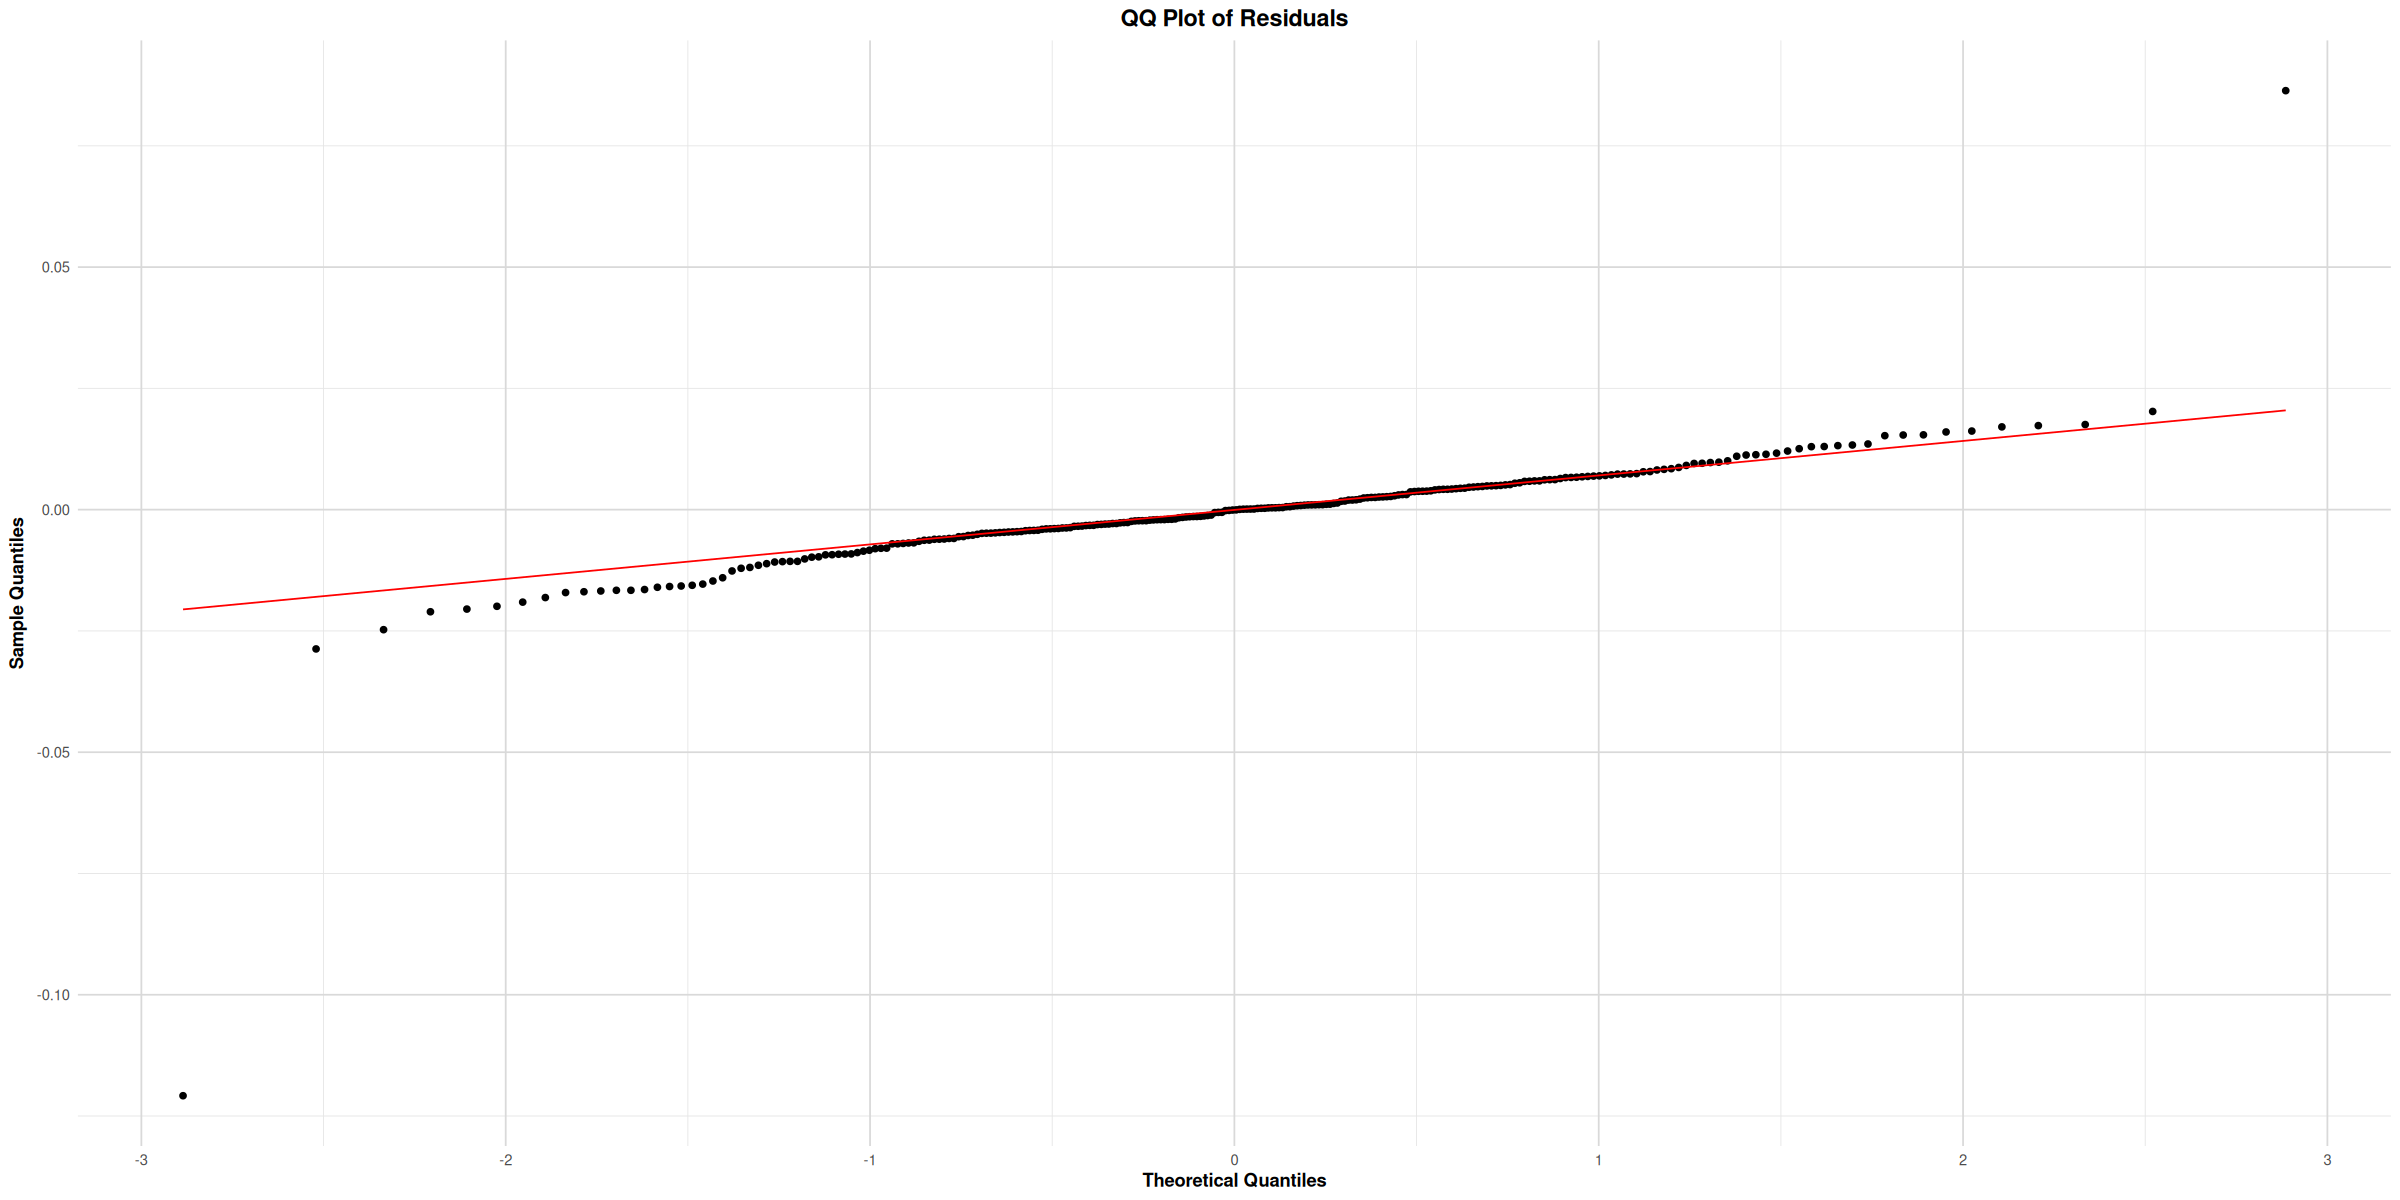

In [27]:
# Extract p and q from best model name safely
p <- tryCatch({
  as.numeric(gsub(".*\\(([0-9]+),1,([0-9]+).*", "\\1", best_model_name))
}, error = function(e) {
  cat("Error extracting p parameter, defaulting to 1\n")
  return(1)
})

q <- tryCatch({
  as.numeric(gsub(".*\\(([0-9]+),1,([0-9]+).*", "\\2", best_model_name))
}, error = function(e) {
  cat("Error extracting q parameter, defaulting to 1\n")
  return(1)
})

# If extraction failed and returned NA, default to 1,1
if (is.na(p)) p <- 1
if (is.na(q)) q <- 1

# Refit best model on full transformed data
cat("Fitting ARIMA(", p, ",1,", q, ") on full data\n", sep="")
final_model <- Arima(transformed_ts, order = c(p, 1, q))

# Check residuals
checkresiduals(final_model)

# Create residuals dataframe for QQ plot
residuals_df <- data.frame(
  Date = gdp_df$date[(length(gdp_df$date) - length(residuals(final_model)) + 1):length(gdp_df$date)],
  Residuals = residuals(final_model)
)

# QQ plot
p_qq <- ggplot(data.frame(Residuals = residuals(final_model)), aes(sample = Residuals)) +
  stat_qq() +
  stat_qq_line(color = "red") +
  labs(
    title = "QQ Plot of Residuals",
    x = "Theoretical Quantiles",
    y = "Sample Quantiles"
  ) +
  theme_tsa()
print(p_qq)

# Normality test
shapiro_test <- shapiro.test(residuals(final_model))
cat("\nShapiro-Wilk test for normality:\n")
print(shapiro_test)
cat("Interpretation: p-value", ifelse(shapiro_test$p.value > 0.05, 
    "> 0.05, residuals appear normally distributed", 
    "< 0.05, residuals not normally distributed"), "\n")

# Ljung-Box test for autocorrelation
lb_test <- Box.test(residuals(final_model), lag = 12, type = "Ljung-Box")
cat("\nLjung-Box test for autocorrelation:\n")
print(lb_test)
cat("Interpretation: p-value", ifelse(lb_test$p.value > 0.05, 
    "> 0.05, no significant autocorrelation remains", 
    "< 0.05, significant autocorrelation remains"), "\n")

# ARCH test for heteroskedasticity
arch_test <- ArchTest(residuals(final_model), lags = 12)
cat("\nARCH test for conditional heteroskedasticity:\n")
print(arch_test)
cat("Interpretation: p-value", ifelse(arch_test$p.value > 0.05, 
    "> 0.05, no significant ARCH effects detected", 
    "< 0.05, ARCH effects present"), "\n")

# Runs test for randomness
runs_test <- tryCatch({
  runs.test(residuals(final_model) > 0)
}, error = function(e) {
  cat("Error in runs test:", e$message, "\n")
  return(list(p.value = NA, statistic = NA))
})

if (!is.na(runs_test$p.value)) {
  cat("\nRuns test for randomness:\n")
  print(runs_test)
  cat("Interpretation: p-value", ifelse(runs_test$p.value > 0.05, 
      "> 0.05, residuals appear random", 
      "< 0.05, residuals may not be random"), "\n")
} else {
  cat("\nRuns test could not be calculated. Consider checking for constant values in residuals.\n")
}